# L0. Introduction

### Define all the imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Change to main repo folder for the imports
_, dir = os.path.split(os.getcwd())
if dir == 'notebooks': 
    os.chdir('..')
    sys.path.append(os.getcwd())
# Ignore warnings from pandas
pd.set_option('mode.chained_assignment', None)

In [2]:
from src.data.reader import Reader

### Define new Functions

In [3]:
def build_timeseries(data,cols):
    timeseries = pd.DataFrame(data, columns=cols)
    timeseries['stamp'] = pd.to_datetime(timeseries['stamp'], unit='s')
    timeseries = timeseries.set_index('stamp')
    return timeseries

In [4]:
def filter_static_landmarks(lm, barcodes):
    for L,l in dict(barcodes).items(): # Translate barcode num to landmark num
        lm[lm==l]=L
    lm = lm[lm.type > 5] # Keep only static landmarks 
    return lm 

The previous block is for defining specific notebook functions

### Load a dataset

In [5]:
# Define dataset to read
dataset = "data/MRCLAM_Dataset1" # Dataset
end_frame = 50000 # Extension of the dataset
robot = 'Robot5' # Robot

# Reader. Go to the src directory using VScode and inspect the class methods
self = Reader(dataset, robot, end_frame)

### Generate some representations

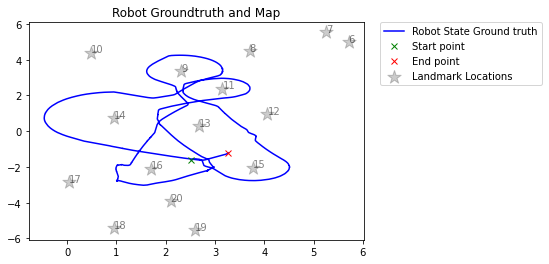

In [6]:
# Ground truth data
plt.plot(self.groundtruth_data[:, 1], self.groundtruth_data[:, 2], 'b', label="Robot State Ground truth")

# Start and end points
plt.plot(self.groundtruth_data[0, 1], self.groundtruth_data[0, 2], 'gx', label="Start point")
plt.plot(self.groundtruth_data[-1, 1], self.groundtruth_data[-1, 2], 'rx', label="End point")

# Landmark ground truth locations and indexes
landmark_xs = []
landmark_ys = []
for location in self.landmark_locations:
    landmark_xs.append(self.landmark_locations[location][0])
    landmark_ys.append(self.landmark_locations[location][1])
    index = self.landmark_indexes[location] + 5
    plt.text(landmark_xs[-1], landmark_ys[-1], str(index), alpha=0.5, fontsize=10)
plt.scatter(landmark_xs, landmark_ys, s=200, c='k', alpha=0.2, marker='*', label='Landmark Locations')

plt.title("Robot Groundtruth and Map")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### TASK EXAMPLE. Represent landmark measurments

#### Import data into pandas dataframes

In [7]:
# Build dataframes
groundtruth = build_timeseries(self.groundtruth_data, cols=['stamp','x','y','theta'])
measurements = build_timeseries(self.data, cols=['stamp','type','range_l','bearing_l'])
odometry = measurements[measurements.type == -1].rename(columns={'range_l': 'v', 'bearing_l': 'omega'})
landmarks = measurements[measurements.type != -1]
landmarks = filter_static_landmarks(landmarks, self.barcodes_data)




In [8]:
groundtruth.head(10)

,x,y,theta
stamp,,,
2009-07-22 14:17:43.324999936,2.514231,-1.614805,1.0114
2009-07-22 14:17:43.345999872,2.514209,-1.614815,1.0114
2009-07-22 14:17:43.377000192,2.514235,-1.614822,1.0111
2009-07-22 14:17:43.398999808,2.514260,-1.614817,1.0112
2009-07-22 14:17:43.424000000,2.514285,-1.614809,1.0114
2009-07-22 14:17:43.443000064,2.514267,-1.614809,1.0114
2009-07-22 14:17:43.472000000,2.514200,-1.614806,1.0113
2009-07-22 14:17:43.492999936,2.514197,-1.614804,1.0113
2009-07-22 14:17:43.523000064,2.514290,-1.614782,1.0113


In [9]:
odometry.head()

,type,v,omega
stamp,,,
2009-07-22 14:17:54.237999872,-1.0,0.086,-0.398
2009-07-22 14:17:54.268999936,-1.0,0.086,-0.398
2009-07-22 14:17:54.288999936,-1.0,0.086,-0.398
2009-07-22 14:17:54.349999872,-1.0,0.086,-0.398
2009-07-22 14:17:54.371000064,-1.0,0.086,-0.398


In [10]:
landmarks.head()

,type,range_l,bearing_l
stamp,,,
2009-07-22 14:17:56.451000064,12.0,2.681,0.467
2009-07-22 14:17:56.680999936,15.0,1.170,-0.577
2009-07-22 14:17:56.918999808,15.0,1.224,-0.483
2009-07-22 14:17:57.155000064,15.0,1.253,-0.407
2009-07-22 14:17:57.394000128,15.0,1.281,-0.325


#### Transform landmark measurements to global coordinates
Join dataframes (link observations to particular GT locations)

In [11]:
data = landmarks.join(groundtruth).dropna()
data.head()

,type,range_l,bearing_l,x,y,theta
stamp,,,,,,
2009-07-22 14:18:49.991000064,17.0,4.594,0.164,4.513066,-1.987889,1.7156
2009-07-22 14:18:49.991000064,13.0,5.585,0.256,4.513066,-1.987889,1.7156
2009-07-22 14:18:55.882999808,10.0,7.136,0.044,4.402364,-1.626464,2.1074
2009-07-22 14:18:55.882999808,13.0,2.610,0.204,4.402364,-1.626464,2.1074
2009-07-22 14:18:56.120000000,13.0,5.439,-0.159,4.393292,-1.611678,2.1307


Transform distance and bearing to global coordinates

In [12]:
range_l = data.range_l
bearing_l = data.bearing_l
x_t = data.x
y_t =  data.y
theta_t = data.theta

x = range_l*np.cos(bearing_l)
y = range_l*np.sin(bearing_l)

data['x_l'] = x_t + x*np.cos(theta_t) - y*np.sin(theta_t)
data['y_l'] = y_t + x*np.sin(theta_t) + y*np.cos(theta_t)
data.head()

,type,range_l,bearing_l,x,y,theta,x_l,y_l
stamp,,,,,,,,
2009-07-22 14:18:49.991000064,17.0,4.594,0.164,4.513066,-1.987889,1.7156,3.116861,2.388805
2009-07-22 14:18:49.991000064,13.0,5.585,0.256,4.513066,-1.987889,1.7156,2.334031,3.154487
2009-07-22 14:18:55.882999808,10.0,7.136,0.044,4.402364,-1.626464,2.1074,0.488063,4.340172
2009-07-22 14:18:55.882999808,13.0,2.610,0.204,4.402364,-1.626464,2.1074,2.641309,0.299877
2009-07-22 14:18:56.120000000,13.0,5.439,-0.159,4.393292,-1.611678,2.1307,2.270720,3.396057


#### Represent measurements on top of our known map

14


/var/folders/bg/3dhcjwyd0fq5knq8krp91ypm0000gn/T/ipykernel_92361/931031336.py:4: UserWarning: The palette list has more values (14) than needed (13), which may not be intended.
  sns.scatterplot(data,x="x_l",y="y_l", hue="type", palette=sns.color_palette("husl", num_landmarks),legend=False)


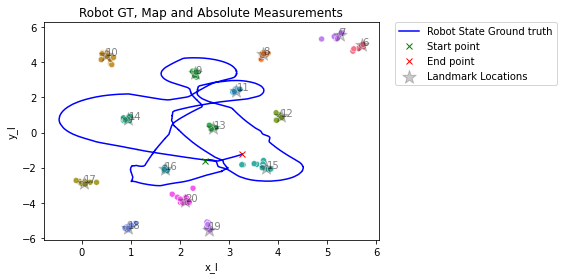

In [16]:
# REPRESENT
# Measurements (New added function)
num_landmarks = len(landmarks.type.unique())
sns.scatterplot(data,x="x_l",y="y_l", hue="type", palette=sns.color_palette("husl", num_landmarks),legend=False)   


# Ground truth data
plt.plot(self.groundtruth_data[:, 1], self.groundtruth_data[:, 2], 'b', label="Robot State Ground truth")

# Start and end points
plt.plot(self.groundtruth_data[0, 1], self.groundtruth_data[0, 2], 'gx', label="Start point")
plt.plot(self.groundtruth_data[-1, 1], self.groundtruth_data[-1, 2], 'rx', label="End point")

# Landmark ground truth locations and indexes
landmark_xs = []
landmark_ys = []
for location in self.landmark_locations:
    landmark_xs.append(self.landmark_locations[location][0])
    landmark_ys.append(self.landmark_locations[location][1])
    index = self.landmark_indexes[location] + 5
    plt.text(landmark_xs[-1], landmark_ys[-1], str(index), alpha=0.5, fontsize=10)
plt.scatter(landmark_xs, landmark_ys, s=200, c='k', alpha=0.2, marker='*', label='Landmark Locations')

# plt.title("Localization with only odometry data")
plt.title("Robot GT, Map and Absolute Measurements")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### TASK 1. Get dataset specifications

#### Get path length
Sum displacements from the GT

#### Get duration

#### Get number of landmark measurements

#### Get distance between initial and end positions

#### Measurements density 
Mean number of measures per unit of distance

### TASK 2. Iterate over diferent datasets


#### Generate metrics

In [ ]:
datasets = ["../data/MRCLAM_Dataset1",
            "../data/MRCLAM_Dataset2",
            "../data/MRCLAM_Dataset3",
            "../data/MRCLAM_Dataset4"]
robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4']

metrics = pd.Dataframe(columns=['dataset','robot','length','duration','n_landmarks','distance','m_density'])

#for ds in datasets:
    #for rob in robots:
        # Load data
        
        # Get metrics

#### Represent metrics
Use seaborn library (catplot)

In [ ]:
# Represent metrics for all datasets

#### Analize metrics

In [ ]:
# Analize the results and select three datasets with different 'distance','m_density' for the next lab sessions.